In [1]:
import xarray as xr, pandas as pd, numpy as np

import cartopy, regionmask, geopandas as gpd
#from shapely.geometry import Polygon

import glob, re
from matplotlib import pyplot as plt


# method to wrap longitude from (0,360) to (-180,180)
def wrap_lon(ds):
    
    if "longitude" in ds.coords:
        lon = "longitude"
        lat = "latitude"
    elif "lon" in ds.coords:
        lon = "lon"
        lat = "lat"
    else: 
        # can only wrap longitude
        return ds
    
    if ds[lon].max() > 180:
        ds[lon] = (ds[lon].dims, (((ds[lon].values + 180) % 360) - 180), ds[lon].attrs)
        
    if lon in ds.dims:
        ds = ds.reindex({ lon : np.sort(ds[lon]) })
        ds = ds.reindex({ lat : np.sort(ds[lat]) })
    return ds

ERROR 1: PROJ: proj_create_from_database: Open of /home/cb2714/conda/envs/wwa/share/proj failed


Useful arguments when plotting:  
`vmin` and `vmax`: set max & min values on colour scale (useful to highlight values other than the absolute maximum & minimum)  

`subplot_kws = {"extent" : (xn,xx,yn,yx)}`: fix the lon & lat in the figures

If you want to change the colormap (`cmap`), the available options are here: https://matplotlib.org/stable/users/explain/colors/colormaps.html

# Download data from the Climate Explorer  

We can get observations from [KNMI's Climate Explorer tool](https://climexp.knmi.nl/start.cgi?id=someone@somewhere)
- sign in to save your searches
- go to 'daily fields' > ERA5 0.25°
- enter the lat/lon bounds of a large region including the area you want to study
- select 'subset of the field' and 'convert to Celsius' / 'convert to mm/day'
- click 'create'
- download the file by copying the link into the cell below
- also download the associated land/sea mask (link at the top of the climate explorer page)

In [2]:
# ! wget https://climexp.knmi.nl/data/era5_t2m_daily_af_34-42E_-5-5N_firstyear-lastyear_su.nc

In [3]:
# ! wget https://climexp.knmi.nl/data/lsmask_era5_t2m_daily_af_34-42E_-5-5N_-999-lastyear_su.nc

# Choosing the region

## Large-scale maps of the 'event'

Start by looking at observations to get an idea of the right region

In [4]:
# change to your filename and variable name
da = wrap_lon(xr.open_dataset("era5_t2m_daily_af_34-42E_-5-5N_-999-lastyear_su.nc").t2m)

In [5]:
# mask out the sea surface (ERA5 only)
lsm = xr.open_dataset("lsmask_era5_t2m_daily_af_34-42E_-5-5N_-999-lastyear_su.nc").lsm.squeeze(drop = True)

da = da.where(lsm >= 0.5) # set any cells with < 50% land to 'NA'

In [6]:
# cut out just the time slice we're interested in
da_event = da.sel(time = slice("2024-07-01","2024-07-10"))

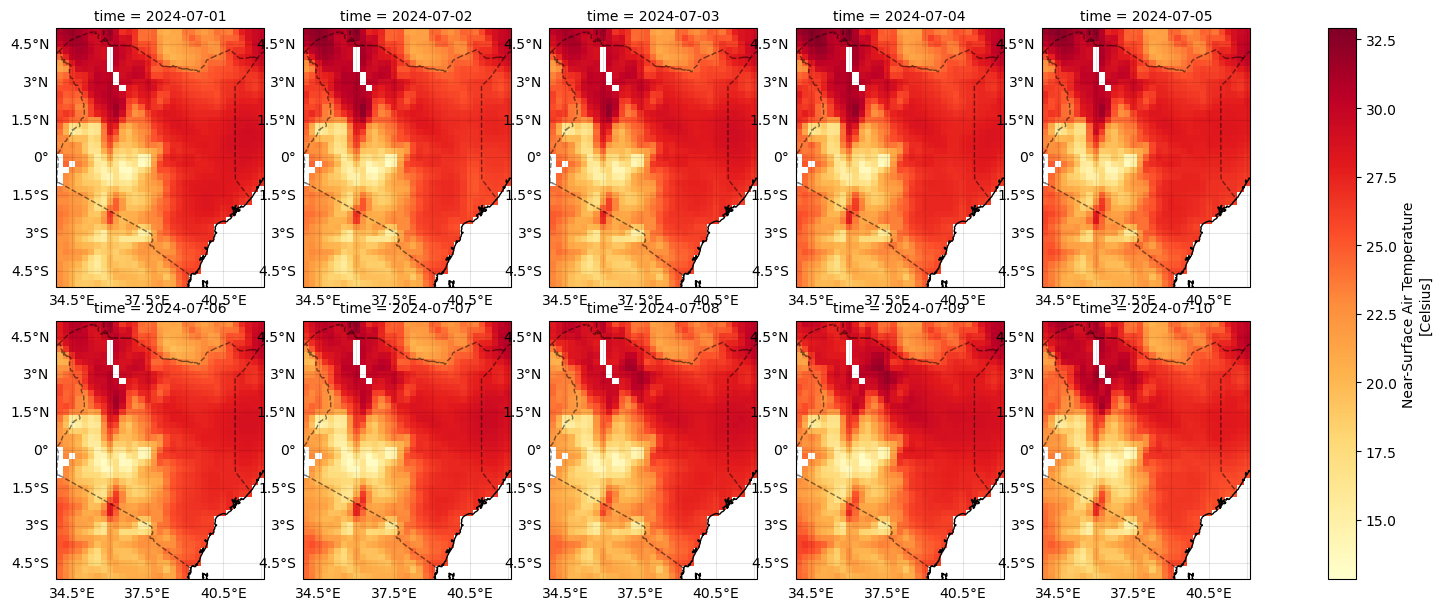

In [7]:
fig = da_event.plot(cmap = "YlOrRd",      # set the colourmap (you can change this)
                    col = "time",         # plot each day in a separate column
                    col_wrap = 5,         # plot 5 panels per row
                    subplot_kws = {"projection" : cartopy.crs.PlateCarree()})    # set geographic projection so we can add geographic features

# add coastlines and borders
for ax in fig.axs.flat:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5, ls = "--")
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

## Anomaly maps

In [8]:
# select just the month(s) you're interested in
da_months = da.sel(time = da.time.dt.month.isin([7]))

da_clim = da_months.sel(time = slice("1990","2020")).mean("time")
da_anom = da_months - da_clim

da_anom = da_anom.sel(time = slice("2024-07-01","2024-07-10"))

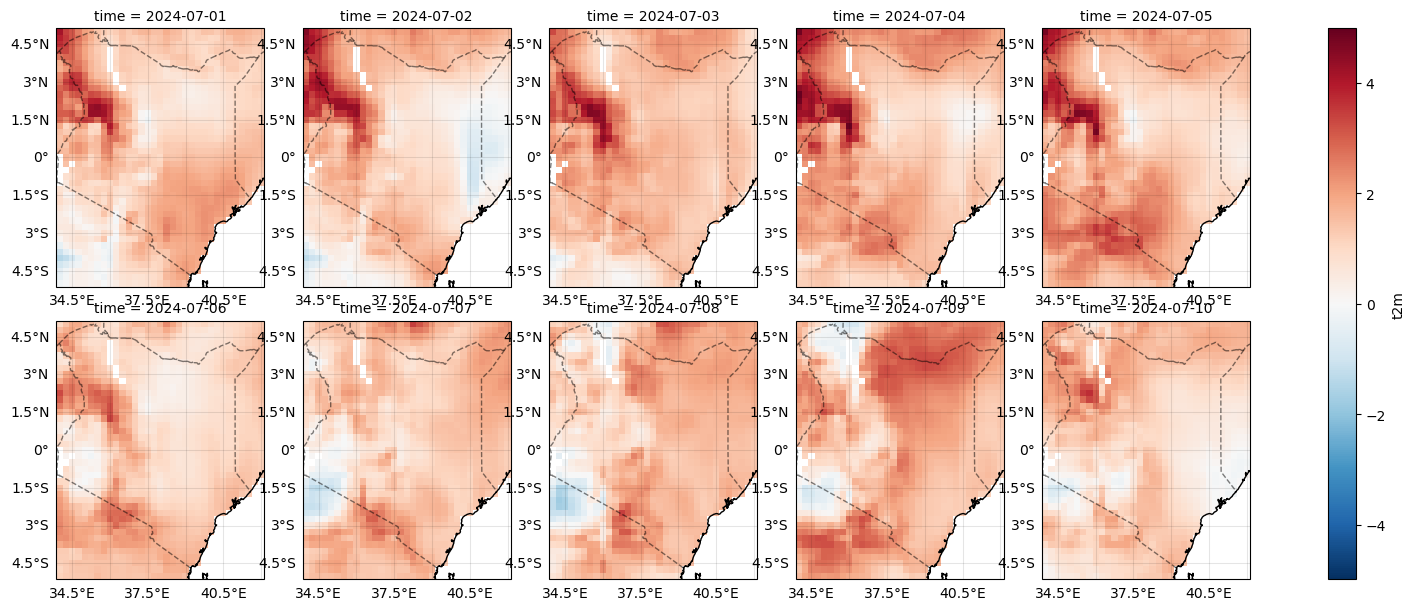

In [9]:
fig = da_anom.plot(cmap = "RdBu_r",      # set the colourmap
                    col = "time",         # plot each day in a separate column
                    col_wrap = 5,         # plot 5 panels per row
                    subplot_kws = {"projection" : cartopy.crs.PlateCarree()})    # set geographic projection so we can add geographic features

# add coastlines and borders
for ax in fig.axs.flat:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5, ls = "--")
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

## Define the study region

**Questions to consider**

- where did the impacts actually occur?
- how far did the associated weather system extend?
- is the proposed region relatively homogeneous in terms of topography?
- is the proposed region relatively homogeneous in terms of climatology?

### Rectangular region

In [10]:
# set the lons & lats to define the edges of the region
xn, xx, yn, yx = [36,38,-1.5,1.5]

## Event maps with study region

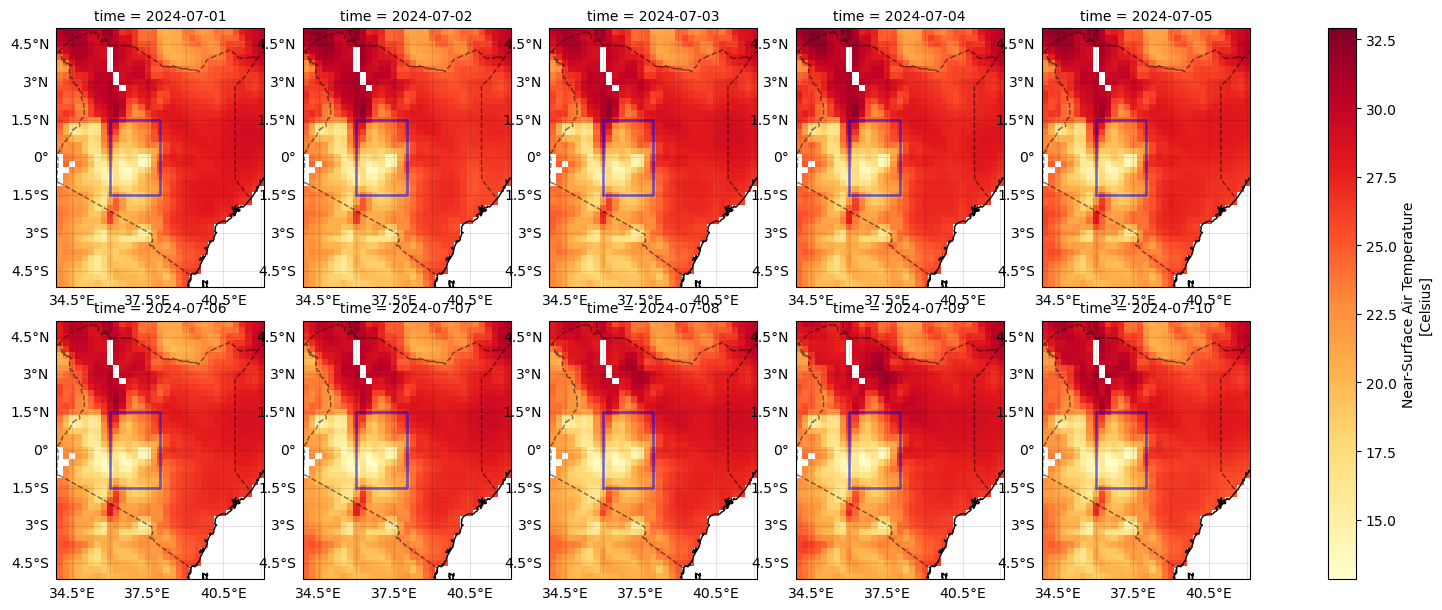

In [11]:
fig = da_event.plot(cmap = "YlOrRd",      # set the colourmap (YlGnBu is good for precip, RdBu_r or YlOrRd for temperature)
                    col = "time",         # plot each day in a separate column
                    col_wrap = 5,         # plot 5 panels per row
                    subplot_kws = {"projection" : cartopy.crs.PlateCarree()})    # set geographic projection so we can add geographic features

# add coastlines and borders
for ax in fig.axs.flat:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5, ls = "--")
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

    # draw a box around the area you're interested
    ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "blue", lw = 2, alpha = 0.5)

## Check physical geography

Download gridded elevation data from the shared directory

In [12]:
# original source for this data - no longer available
# !wget http://research.jisao.washington.edu/data_sets/elevation/elev.0.25-deg.nc

In [13]:
elev = wrap_lon(xr.open_dataset("elev.0.25-deg.nc", decode_times = False).data.squeeze(drop = True))

/home/cb2714/conda/envs/wwa/lib/python3.13/site-packages/xarray/coding/times.py:213: SerializationWarning: Ambiguous reference date string: 1-1-1 0:0:0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 0:0:0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  ref_date = _ensure_padded_year(ref_date)


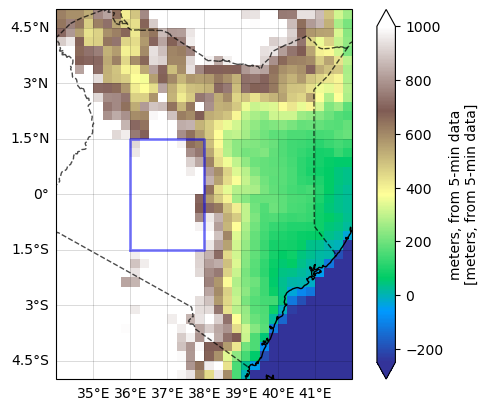

In [14]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cartopy.crs.PlateCarree(),
                                     "extent" : (da.lon.min(),da.lon.max(),da.lat.min(),da.lat.max())})
elev_kwargs = {"cmap" : "terrain",
               "vmin" : -250, 
               "vmax" : 1000}    # aim to keep vmin:vmax at 1:4 ratio to change from blue to green at zero

elev.plot(ax = ax, **elev_kwargs)

ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.2)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)

# add box around area of interest
ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "blue", lw = 2, alpha = 0.5)

## Extract daily time series

Once you're happy with the study region, we need to extract a time series of the average temp/precip over the area

In [15]:
# average all values over the selected region and save as a netcdf
ts = da.sel(lon = slice(xn,xx), lat = slice(yn,yx)).mean(["lat", "lon"])
ts.to_netcdf("example_timeseries.nc")

# Choosing the duration & season

**Questions to consider**

- did the impacts arise from a short-term event or was the whole month/season unusual?
- was the event unusual only for a given time of year? For a particular month(s) or season?

Text(0.5, 1.0, '')

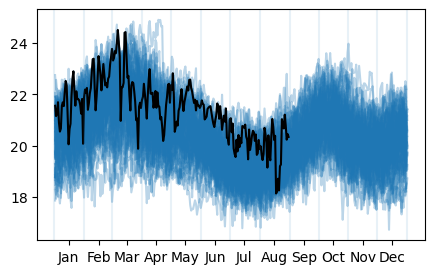

In [16]:
# How unusual was this year?
fig, ax = plt.subplots(ncols = 1, figsize = (5,3), dpi = 100)

# loop over each year & plot the annual time series
for y in np.unique(ts.time.dt.year):
    ts_y = ts.sel(time = str(y))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.3)

# add the event year in a different colour
ts_y = ts.sel(time = "2025")
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k")

# make nicer x-axis labels (don't change this part)
days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(len(days)) if (days[i].day) == 15]
labels = [days[i].strftime("%b") for i in range(len(days)) if (days[i].day) == 15]

[ax.axvline(i, alpha = 0.1) for i in range(len(days)) if (days[i].day) == 1]
ax.set_xticks(labelticks)
ax.set_xticklabels(labels)

ax.set_title("")

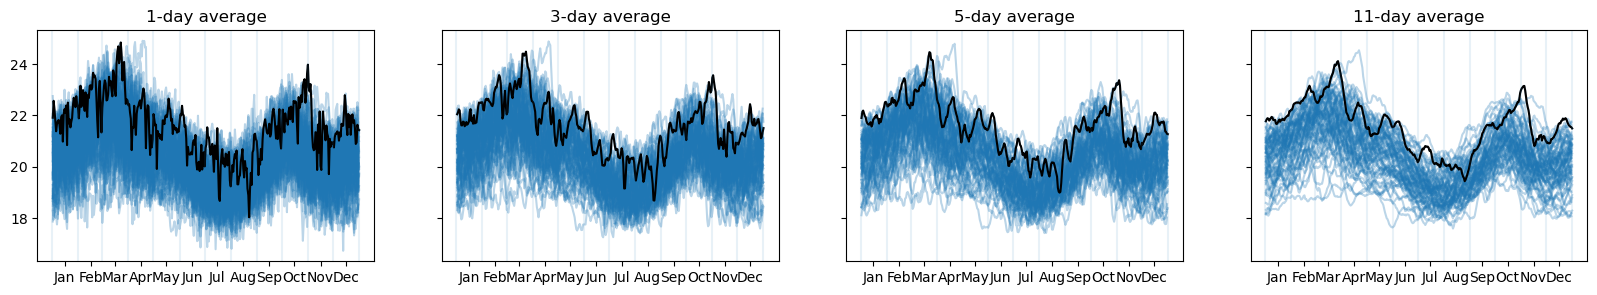

In [17]:
# Compare a few accumulations
fig, axs = plt.subplots(ncols = 4, figsize = (20,3), dpi = 100, sharey = True)

# loop over each year & plot the annual time series
for i in range(4):
    ax = axs[i]
    ndays = [1,3,5,11][i]     # change the numbers of days to compare different accumulations
    
    ts_nday = ts.rolling(time = ndays, center = False).mean()
    
    for y in np.unique(ts.time.dt.year):
        ts_y = ts_nday.sel(time = str(y))
        ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.3)

    # add this year in a different colour
    ts_y = ts_nday.sel(time = "2024")
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k") 
        
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(i, alpha = 0.1) for i in range(367) if (days[i].day) == 1]
    
    ax.set_title(str(ndays)+"-day average")
    
    # # add a rectangle shading the time period of interest (get & set ylims to avoid resizing the plot)
    # ylim = ax.get_ylim()
    # ax.add_patch(Rectangle((pr_ts.sel(time = "2023-07-01").time.dt.dayofyear.values,-5), 20, 300, color = "gold", alpha = 0.3)) # 20-day period starting from July 1st
    # ax.set_ylim(ylim)
    
    

# Computing the final time series

In [18]:
# compute the selected n-day average
ts_nday = ts.rolling(time = 1, center = False).mean()

# choose which months to include in the analysis
ts_nday = ts_nday.sel(time = ts_nday.time.dt.month.isin([9]))

# get the annual maximum. Think about when to cut the year - 
ts_annual = ts_nday.resample(time = "YS-JAN").max()

# relabel dates as years
ts_annual = ts_annual.assign_coords(time = ts_annual.time.dt.year).rename(time = "year")

In [19]:
# save as a .csv to import into R for further analysis
ts_annual.to_dataframe().to_csv("ts_era5.csv")

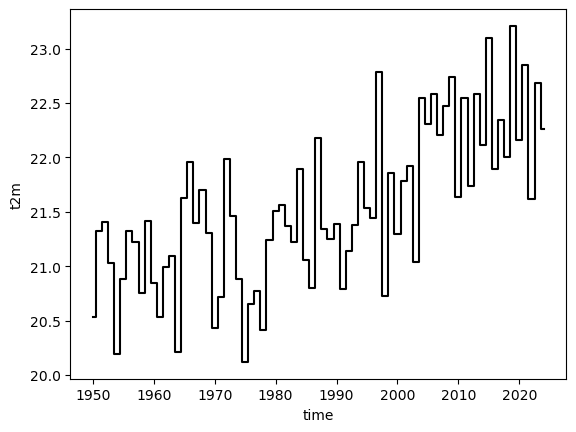

In [20]:
# quick plot - what does the time series look like?
ts_annual.plot(drawstyle = "steps-mid", color = "k")

# Next steps

Repeat for more observational datasets
- CPC (global, temperature & precipitation, low-resolution)
- CHIRPS (Global up to 60N, precipitation - better at extreme rainfall)
-  TAMSAT (Africa, precipitation - designed to detect droughts but may have some dry bias)
- You may be able to find other datasets for specific regions

Do all datasets show similar trends?

**Next: load the data in R and do some statistical analysis**